In [1]:
# Load modules
import os
from scipy.optimize import curve_fit
from scipy import exp
from matplotlib.ticker import MultipleLocator


P.style.use(['seaborn-white', 'seaborn-paper', 'seaborn-ticks'])



# V471Tau
period =  0.5211833875 # from Vaccaro 2015 
To = 2445821.898291
Omega = 2*N.pi/(period * 24 * 3600.)
c = 299792.
# Central wavelengths
lamb0_ha = 6561.
lamb0_hb = 4861.
lande = 1.2
rstar = 0.93709*696340. # in km
vsin = 89.3 #km/s

# Paths to data
PATH_ha = '/Users/bzaire/lsd/spectra/v471tau/v471tau_int04/halpha'
PATH_hb = '/Users/bzaire/lsd/spectra/v471tau/v471tau_int04/hbeta'

In [2]:

################### Tools ######################
# Because of its orbital motion, V471 Tau requires an interpolated spec 
# to create a mean profile.
def interp_data(x, y, z):
    ''' Interpolate a matrix Z in its x direction, 
        so all the y positions have a structured 
        grid in x.          
    '''
    yvals = (y%1)
    vmin = min([min(i) for i in x])
    vmax = max([max(i) for i in x])
    xvals = N.arange(vmin, vmax, 1.8)
    X, Y = N.meshgrid(xvals, yvals)
    Z = N.zeros_like(X)
    for i in range(y.shape[0]):
        Z[i, :] = N.interp(xvals, x[i], z[i])
    return xvals, yvals, Z

def normPlasma_ha(vr, I):
    ''' Normalize spectra using a linear fit of the 
        ir, il positional points.
    '''
    ir = [0,1,2]; il = [-1,-2,-3]
    vrr = vr[ir].mean(); vrl = vr[il].mean()
    stokesr = I[ir].mean(); stokesl = I[il].mean()
    fit_cont = N.poly1d(N.polyfit((vrr, vrl), (stokesr, stokesl), deg=1))
    return fit_cont(vr), I/fit_cont(vr)

def normPlasma_hb(vr, I):
    ''' Normalize spectra using a linear fit of the 
        ir, il positional points.
    '''
    ir = [0,1,2,3,4,5,6,7]; il = [-1,-2,-3,-4,-5,-6,-7,-8]
    vrr = vr[ir].mean(); vrl = vr[il].mean()
    stokesr = I[ir].mean(); stokesl = I[il].mean()
    fit_cont = N.poly1d(N.polyfit((vrr, vrl), (stokesr, stokesl), deg=1))
    return fit_cont(vr), I/fit_cont(vr)



def gaus(x,a,x0,sigma):
    # Gaussian
    return a*exp(-(x-x0)**2/(2*sigma**2))
################################################


# Prominence in 2004

## H$\alpha$ line

In [3]:

# Change directory
os.chdir(PATH_ha)

# Read data
cycleI_ha, vrI_ha, snI_ha, I_ha, cycleV_ha, vrV_ha, snV_ha, V_ha =  rstokes('v471tau_04.ss')

# Interpolate data to create a mean profile
vr_ha, phase_ha, Z_ha = interp_data(vrI_ha, cycleI_ha, I_ha)


## Create a mean profile for the hot plasma at phase 0.75.
Dp=0.02  # Phase interval to performe the average
it = (phase_ha > 0.75 - Dp)  & (phase_ha < 0.75 + Dp)
#
meanZ_ha = Z_ha[it,:].mean(axis=0)

########### Only for comparison ################
compare_avg=False # Set compare_avg to True to visualize the averages 
                  # considering distinct phase intervals. 
if compare_avg:
    # Define phases where the plasma apears close to its maximum
    Dp0=0.01
    it0 = (phase_ha > 0.75 - Dp)  & (phase_ha < 0.75 + Dp)
    print('Mean profile from N =', N.ones_like(phase_ha)[it].sum())
    Dp1=0.02
    it1 = (phase_ha > 0.75 - Dp1)  & (phase_ha < 0.75 + Dp1)
    print('Mean profile from N =', N.ones_like(phase_ha)[it1].sum())
    Dp2=0.04
    it2 = (phase_ha > 0.75 - Dp2)  & (phase_ha < 0.75 + Dp2)
    print('Mean profile from N =', N.ones_like(phase_ha)[it2].sum())
   
    # Create mean profile considerig the distinct average intervals
    meanZ0_ha = Z_ha[it0,:].mean(axis=0)
    meanZ1_ha = Z_ha[it1,:].mean(axis=0)
    meanZ2_ha = Z_ha[it2,:].mean(axis=0)
    
    # label shows the number of profiles used in average!!!
    P.plot(vr_ha, meanZ0_ha, 'r', label = 'N = %d' %N.ones_like(phase_ha)[it0].sum())
    P.plot(vr_ha, meanZ1_ha, 'g', label = 'N = %d' %N.ones_like(phase_ha)[it1].sum())
    P.plot(vr_ha, meanZ2_ha, 'b', label = 'N = %d' %N.ones_like(phase_ha)[it2].sum())
    P.legend()
    P.title(r'Mean H$\alpha$ profile', fontsize='large')
    P.show()
#################################################


## Now we cut the interval in radial velocity to isolate the plasma emission
Kplasma = 210.  # semi-amplitude of the prominence; in km/s

Dvr =  100.     # in km/s  --- Warning! It cannot exceed 125 km/s, otherwise
                #             it will reach the stellar surface (unphysical).
    
ivr_ha = (vr_ha > Kplasma - Dvr)  & (vr_ha < Kplasma + Dvr)
meanZPlasma_ha = meanZ_ha[ivr_ha]    # Plasma emission
vrPlasma_ha = vr_ha[ivr_ha]          # New radial velocity around the plasma emission

# We just need now to renormilize the plasma contribution
renormLinear_ha, IPlasma_ha = normPlasma_ha(vrPlasma_ha, meanZPlasma_ha)


## Fit gaussian to Halpha profile

y_ha = IPlasma_ha - 1
x_ha = vrPlasma_ha - Kplasma

n_ha = len(x_ha)   # number of data
mean = sum(x_ha*y_ha)/n_ha           
sigma = sum(y_ha*(x_ha-mean)**2)/n_ha     

 
popt_ha, pcov_ha = curve_fit(gaus,x_ha,y_ha,p0=[1, mean, sigma])
sigma_ha = popt_ha[2]

# Equivalent width 
intI_ha = N.trapz(y=y_ha, x=vrPlasma_ha)
eqwHa = intI_ha*lamb0_ha/c

# FWHM; in km/s
FWHM_ha_kms = sigma_ha*2.355 

# FWHM; in Angstroms
FWHM_ha = FWHM_ha_kms*lamb0_ha/c 

# FWHM; in Rstar:
FWHM_ha_Rstar = FWHM_ha_kms/vsin

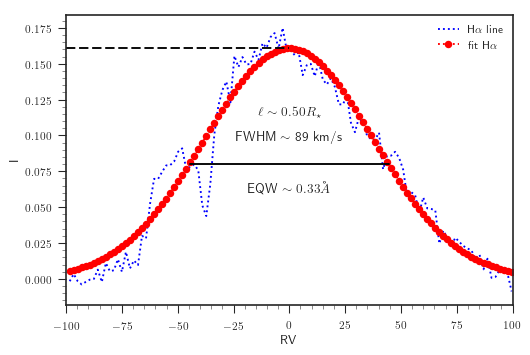

In [4]:
fig, ax = P.subplots(figsize=(6,4), dpi=96)
P.plot(x_ha, y_ha,'b+:',label=r'H$\alpha$ line')
P.plot(x_ha, gaus(x_ha,*popt_ha),'ro:',label=r'fit H$\alpha$')
P.plot(N.linspace(-Dvr,0,30), N.ones(30)*gaus(0,*popt_ha), dashes=[5,2], color='k')
# FWHM
P.plot(N.linspace(-FWHM_ha_kms/2.,FWHM_ha_kms/2,30), N.ones(30)*gaus(0,*popt_ha)/2, color='k')
P.text(0, gaus(0,*popt_ha)*0.6, r'FWHM $\sim$ %d km/s' %(FWHM_ha_kms), ha='center')
P.text(0, gaus(0,*popt_ha)*0.7, r'$\ell \sim %1.2f R_\star$' %(FWHM_ha_Rstar/2.), ha='center')
# EQW
P.text(0, 0.06, r'EQW $\sim %1.2f \AA$' %(eqwHa), ha='center')
ax.yaxis.set_minor_locator(MultipleLocator(0.005))
ax.xaxis.set_minor_locator(MultipleLocator(5))
P.legend()
P.xlim((-Dvr, Dvr))
P.xlabel('RV')
P.ylabel('I')
P.show()

## H$\beta$ line

In [5]:
# Change directory
os.chdir(PATH_hb)

# Read data
cycleI_hb, vrI_hb, snI_hb, I_hb, cycleV_hb, vrV_hb, snV_hb, V_hb =  rstokes('v471tau_04.ss')

# Interpolate data to create a mean profile
vr_hb, phase_hb, tmp_Z_hb = interp_data(vrI_hb, cycleI_hb, I_hb)


### WAARNING: next step is only used for Hbeta
# Clean the Hb profile to evidence the hot plasma;
# using the prominence free spec obtained in 2005.
Z_hb = N.zeros_like(tmp_Z_hb)
cycleI05, vrI05, snI05, I05, cycleV05, vrV05, snV05, V05 =  rstokes('/Users/bzaire/lsd/spectra/v471tau/v471tau_int05/hbeta/v471tau_05.ss')
vr05, phase05, removeZ05 = interp_data(vrI05, cycleI05, I05)
for i in range(phase_hb.shape[0]):
    j = N.argmin(N.abs(phase05 - phase_hb[i]))
    Z_hb[i,:] = tmp_Z_hb[i,:] - removeZ05[j,:] + 1




## Create a mean profile for the hot plasma at phase 0.75.
Dp=0.02  # Phase interval to performe the average
it = (phase_hb > 0.75 - Dp)  & (phase_hb < 0.75 + Dp)
#
meanZ_hb = Z_hb[it,:].mean(axis=0)

########### Only for comparison ################
compare_avg=False # Set compare_avg to True to visualize the averages 
                  # considering distinct phase intervals. 
if compare_avg:
    # Define phases where the plasma apears close to its maximum
    Dp0=0.01
    it0 = (phase_hb > 0.75 - Dp)  & (phase_hb < 0.75 + Dp)
    print('Mean profile from N =', N.ones_like(phase_hb)[it].sum())
    Dp1=0.02
    it1 = (phase_hb > 0.75 - Dp1)  & (phase_hb < 0.75 + Dp1)
    print('Mean profile from N =', N.ones_like(phase_hb)[it1].sum())
    Dp2=0.04
    it2 = (phase_hb > 0.75 - Dp2)  & (phase_hb < 0.75 + Dp2)
    print('Mean profile from N =', N.ones_like(phase_hb)[it2].sum())
   
    # Create mean profile considerig the distinct average intervals
    meanZ0_hb = Z_hb[it0,:].mean(axis=0)
    meanZ1_hb = Z_hb[it1,:].mean(axis=0)
    meanZ2_hb = Z_hb[it2,:].mean(axis=0)
    
    # label shows the number of profiles used in average!!!
    P.plot(vr_hb, meanZ0_hb, 'r', label = 'N = %d' %N.ones_like(phase_hb)[it0].sum())
    P.plot(vr_hb, meanZ1_hb, 'g', label = 'N = %d' %N.ones_like(phase_hb)[it1].sum())
    P.plot(vr_hb, meanZ2_hb, 'b', label = 'N = %d' %N.ones_like(phase_hb)[it2].sum())
    P.legend()
    P.title(r'Mean H$\beta$ profile', fontsize='large')
    P.show()
#################################################


## Now we cut the interval in radial velocity to isolate the plasma emission
Kplasma = 210.  # semi-amplitude of the prominence; in km/s

Dvr =  100.     # in km/s  --- Warning! It cannot exceed 125 km/s, otherwise
                #             it will reach the stellar surface (unphysical).
    
ivr_hb = (vr_hb > Kplasma - Dvr)  & (vr_hb < Kplasma + Dvr)
meanZPlasma_hb = meanZ_hb[ivr_hb]    # Plasma emission
vrPlasma_hb = vr_hb[ivr_hb]          # New radial velocity around the plasma emission

# We just need now to renormilize the plasma contribution
renormLinear_hb, IPlasma_hb = normPlasma_hb(vrPlasma_hb, meanZPlasma_hb)


## Fit gaussian to Halpha profile

y_hb = IPlasma_hb - 1
x_hb = vrPlasma_hb - Kplasma

n_hb = len(x_hb)   # number of data
mean = sum(x_hb*y_hb)/n_hb           
sigma = sum(y_hb*(x_hb-mean)**2)/n_hb    

 
popt_hb, pcov_hb = curve_fit(gaus,x_hb,y_hb,p0=[1, mean, sigma])
sigma_hb = popt_hb[2]

# Equivalent width 
intI_hb = N.trapz(y=y_hb, x=vrPlasma_hb)
eqwHb = intI_hb*lamb0_hb/c

# FWHM; in km/s
FWHM_hb_kms = sigma_hb*2.355 

# FWHM; in Angstroms
FWHM_hb = FWHM_hb_kms*lamb0_hb/c 

# FWHM; in Rstar:
FWHM_hb_Rstar = FWHM_hb_kms/vsin

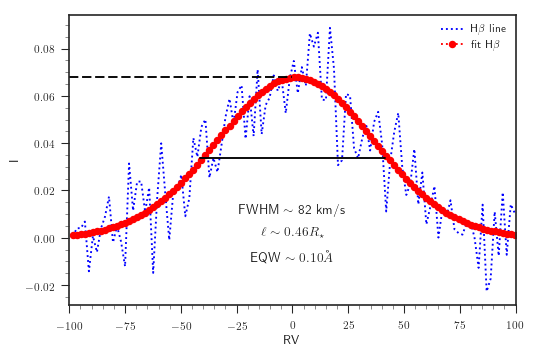

In [6]:
fig, ax = P.subplots(figsize=(6,4), dpi=96)
P.plot(x_hb, y_hb,'b+:',label=r'H$\beta$ line')
P.plot(x_hb, gaus(x_hb,*popt_hb),'ro:',label=r'fit H$\beta$')
P.plot(N.linspace(-Dvr,0,30), N.ones(30)*gaus(0,*popt_hb), dashes=[5,2], color='k')
# FWHM
P.plot(N.linspace(-FWHM_hb_kms/2.,FWHM_hb_kms/2,30), N.ones(30)*gaus(0,*popt_hb)/2, color='k')
P.text(0, 0.01, r'FWHM $\sim$ %d km/s' %(FWHM_hb_kms), ha='center')
P.text(0, 0.0, r'$\ell \sim %1.2f R_\star$' %(FWHM_hb_Rstar/2.), ha='center')
# EQW
P.text(0, -0.01, r'EQW $\sim %1.2f \AA$' %(eqwHb), ha='center')
ax.yaxis.set_minor_locator(MultipleLocator(0.005))
ax.xaxis.set_minor_locator(MultipleLocator(5))
P.legend()
P.xlim((-Dvr, Dvr))
P.xlabel('RV')
P.ylabel('I')
P.show()

# Comparison

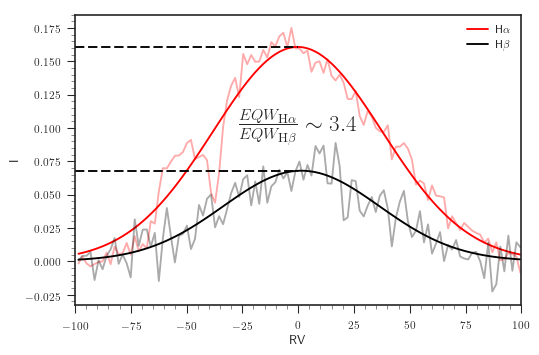

In [7]:
fig, ax = P.subplots(figsize=(6,4), dpi=96)
# Ha
P.plot(x_ha, gaus(x_ha,*popt_ha),'r',label=r'H$\alpha$')
P.plot(x_ha, y_ha,'r', alpha=1./3)
P.plot(N.linspace(-Dvr,0,30), N.ones(30)*gaus(0,*popt_ha), dashes=[5,2], color='k')
# Hb
P.plot(x_hb, gaus(x_hb,*popt_hb),'k',label=r'H$\beta$')
P.plot(x_hb, y_hb,'k', alpha=1./3)
P.plot(N.linspace(-Dvr,0,30), N.ones(30)*gaus(0,*popt_hb), dashes=[5,2], color='k')
# EQW
P.text(0, 0.09, r'$\frac{EQW_\mathrm{H\alpha}}{EQW_\mathrm{H\beta}}\sim %1.1f$' %(eqwHa/eqwHb), ha='center', fontsize='xx-large')
ax.yaxis.set_minor_locator(MultipleLocator(0.005))
ax.xaxis.set_minor_locator(MultipleLocator(5))
P.legend()
P.xlim((-Dvr, Dvr))
P.xlabel('RV')
P.ylabel('I')
P.show()